In [1]:
# Parameters
run_id = "20251023-053615"
auto_download = "true"


# Association Rules Mining Tutorial

**Dataset:** Groceries Market Basket  
**Source:** Kaggle - Groceries dataset  
**Task:** Discover association rules between items purchased together
**Library:** MLxtend (PyCaret 3.x dropped association rules module)

---

## What is Association Rule Mining?

Association rule mining discovers interesting relationships between items in large datasets. Common applications:

- **Market Basket Analysis** - What products are bought together?
- **Recommendation Systems** - "Customers who bought X also bought Y"
- **Web Usage Mining** - Which pages are visited together?
- **Medical Diagnosis** - Which symptoms appear together?

### Key Concepts

- **Support**: How frequently items appear together
- **Confidence**: How often rule is true
- **Lift**: How much more likely items appear together than expected

---

## Environment Setup

In [2]:
# Verify environment
import sys
print(f"Python version: {sys.version}")

import mlxtend
import pandas as pd
import numpy as np

print(f"\nMLxtend version: {mlxtend.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

Python version: 3.10.19 | packaged by conda-forge | (main, Oct 22 2025, 22:29:10) [GCC 14.3.0]



MLxtend version: 0.23.4
Pandas version: 2.1.4
NumPy version: 1.26.4


## Load Dataset

The Groceries dataset contains transactions from a grocery store with:
- **Member_number**: Transaction ID (unique per basket)
- **Date**: Purchase date
- **itemDescription**: Item purchased

In [3]:
from pathlib import Path
import pandas as pd

# Setup data directory
data_dir = Path('../datasets/association')
data_dir.mkdir(parents=True, exist_ok=True)

data_path = data_dir / 'Groceries_dataset.csv'

# Download from Kaggle if not already present
if not data_path.exists():
    print(f"📥 Downloading dataset from Kaggle...")
    
    # Check for Kaggle credentials
    kaggle_json = Path.home() / '.kaggle' / 'kaggle.json'
    
    if not kaggle_json.exists():
        print("⚠️  Kaggle credentials not found!")
        print("\nTo download datasets automatically, you need Kaggle API credentials:")
        print("1. Go to https://www.kaggle.com/settings")
        print("2. Scroll to 'API' section and click 'Create New API Token'")
        print("3. This downloads kaggle.json")
        print("4. Place it in ~/.kaggle/kaggle.json")
        print("   mkdir -p ~/.kaggle && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json")
        raise Exception("Please set up Kaggle credentials to download the dataset")
    else:
        # Download using Kaggle API
        import kaggle
        print(f"Downloading from Kaggle: heeraldedhia/groceries-dataset")
        kaggle.api.dataset_download_files(
            'heeraldedhia/groceries-dataset',
            path=data_dir,
            unzip=True,
            quiet=False
        )
        print(f"✅ Dataset downloaded to {data_dir}")
else:
    print(f"✅ Dataset already exists at {data_path}")

# Load the data
print(f"\n📊 Loading dataset...")
data = pd.read_csv(data_path)

print(f"Dataset shape: {data.shape}")
print(f"\nColumns: {list(data.columns)}")
print(f"\nNumber of unique transactions: {data['Member_number'].nunique()}")
print(f"Number of unique items: {data['itemDescription'].nunique()}")

# Display first few rows
data.head(20)

✅ Dataset already exists at ../datasets/association/Groceries_dataset.csv

📊 Loading dataset...
Dataset shape: (38765, 3)

Columns: ['Member_number', 'Date', 'itemDescription']

Number of unique transactions: 3898
Number of unique items: 167


,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk
5,4941,14-02-2015,rolls/buns
6,4501,08-05-2015,other vegetables
7,3803,23-12-2015,pot plants
8,2762,20-03-2015,whole milk
9,4119,12-02-2015,tropical fruit


In [4]:
# Check most popular items
print("Top 20 Most Popular Items:")
item_counts = data['itemDescription'].value_counts().head(20)
print(item_counts)

Top 20 Most Popular Items:
itemDescription
whole milk            2502
other vegetables      1898
rolls/buns            1716
soda                  1514
yogurt                1334
root vegetables       1071
tropical fruit        1032
bottled water          933
sausage                924
citrus fruit           812
pastry                 785
pip fruit              744
shopping bags          731
canned beer            717
bottled beer           687
whipped/sour cream     662
newspapers             596
frankfurter            580
brown bread            571
pork                   566
Name: count, dtype: int64


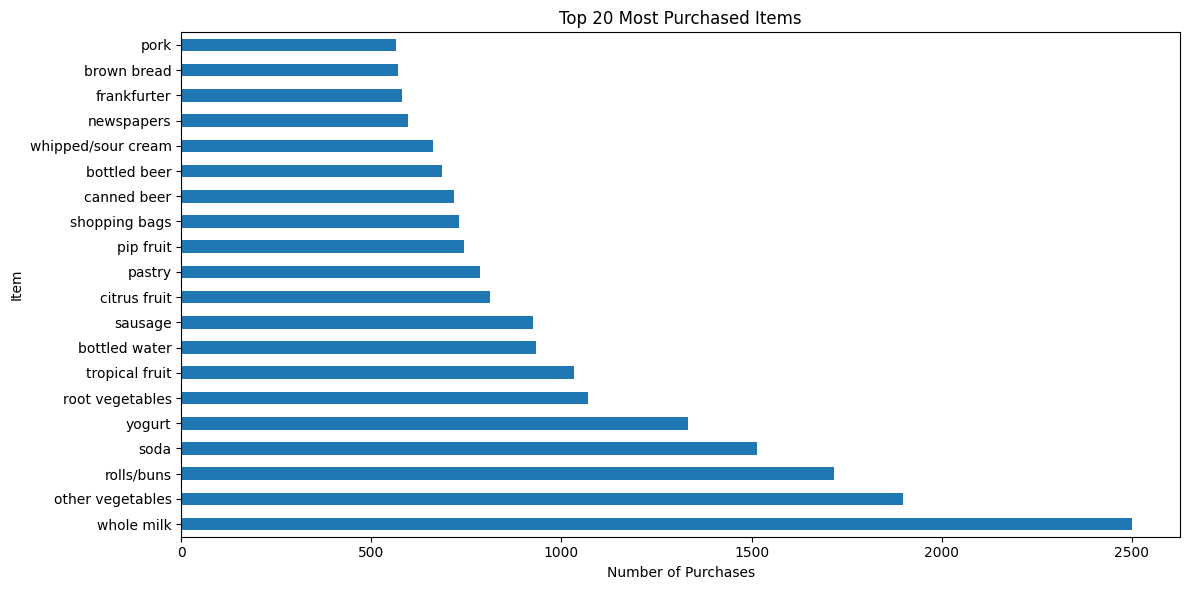

In [5]:
# Visualize top items
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
item_counts.plot(kind='barh')
plt.title('Top 20 Most Purchased Items')
plt.xlabel('Number of Purchases')
plt.ylabel('Item')
plt.tight_layout()
plt.show()

## Data Preprocessing

Convert transaction data to one-hot encoded format required by mlxtend.

In [6]:
# Group items by transaction
transactions = data.groupby('Member_number')['itemDescription'].apply(list).reset_index()

print(f"Number of transactions: {len(transactions)}")
print(f"\nExample transaction:")
print(f"Transaction ID: {transactions.iloc[0]['Member_number']}")
print(f"Items: {transactions.iloc[0]['itemDescription']}")

Number of transactions: 3898

Example transaction:
Transaction ID: 1000
Items: ['soda', 'canned beer', 'sausage', 'sausage', 'whole milk', 'whole milk', 'pickled vegetables', 'misc. beverages', 'semi-finished bread', 'hygiene articles', 'yogurt', 'pastry', 'salty snack']


In [7]:
from mlxtend.preprocessing import TransactionEncoder

# Convert to one-hot encoded format
te = TransactionEncoder()
te_ary = te.fit(transactions['itemDescription']).transform(transactions['itemDescription'])
basket = pd.DataFrame(te_ary, columns=te.columns_)

print(f"Basket shape: {basket.shape}")
print(f"\nFirst few rows:")
basket.head()

Basket shape: (3898, 167)

First few rows:


,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
1,False,False,False,False,False,False,False,False,True,False,...,False,False,False,True,False,True,False,True,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


## Generate Frequent Itemsets

Use the Apriori algorithm to find frequent itemsets.

In [8]:
from mlxtend.frequent_patterns import apriori

# Find frequent itemsets with minimum support of 1%
frequent_itemsets = apriori(basket, min_support=0.01, use_colnames=True)

print(f"Number of frequent itemsets: {len(frequent_itemsets)}")
print(f"\nTop 20 by support:")
frequent_itemsets.sort_values('support', ascending=False).head(20)

Number of frequent itemsets: 3016

Top 20 by support:


,support,itemsets
113,0.458184,(whole milk)
69,0.376603,(other vegetables)
84,0.349666,(rolls/buns)
94,0.313494,(soda)
114,0.282966,(yogurt)
106,0.233710,(tropical fruit)
85,0.230631,(root vegetables)
7,0.213699,(bottled water)
89,0.206003,(sausage)
1050,0.191380,"(other vegetables, whole milk)"


## Generate Association Rules

In [9]:
from mlxtend.frequent_patterns import association_rules

# Generate association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

print(f"Number of rules discovered: {len(rules)}")
print(f"\nColumns: {list(rules.columns)}")
rules.head(20)

Number of rules discovered: 15260

Columns: ['antecedents', 'consequents', 'antecedent support', 'consequent support', 'support', 'confidence', 'lift', 'representativity', 'leverage', 'conviction', 'zhangs_metric', 'jaccard', 'certainty', 'kulczynski']


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(UHT-milk),(beef),0.078502,0.119548,0.010518,0.133987,1.120775,1.0,0.001133,1.016672,0.116940,0.056088,0.016399,0.110985
1,(beef),(UHT-milk),0.119548,0.078502,0.010518,0.087983,1.120775,1.0,0.001133,1.010396,0.122392,0.056088,0.010289,0.110985
2,(bottled beer),(UHT-milk),0.158799,0.078502,0.014879,0.093700,1.193597,1.0,0.002413,1.016769,0.192815,0.066897,0.016492,0.141621
3,(UHT-milk),(bottled beer),0.078502,0.158799,0.014879,0.189542,1.193597,1.0,0.002413,1.037933,0.176014,0.066897,0.036547,0.141621
4,(UHT-milk),(bottled water),0.078502,0.213699,0.021293,0.271242,1.269268,1.0,0.004517,1.078960,0.230217,0.078598,0.073181,0.185441
5,(bottled water),(UHT-milk),0.213699,0.078502,0.021293,0.099640,1.269268,1.0,0.004517,1.023477,0.269801,0.078598,0.022939,0.185441
6,(UHT-milk),(brown bread),0.078502,0.135967,0.012314,0.156863,1.153681,1.0,0.001640,1.024783,0.144557,0.060914,0.024184,0.123714
7,(brown bread),(UHT-milk),0.135967,0.078502,0.012314,0.090566,1.153681,1.0,0.001640,1.013266,0.154172,0.060914,0.013092,0.123714
8,(UHT-milk),(butter),0.078502,0.126475,0.010518,0.133987,1.059394,1.0,0.000590,1.008674,0.060840,0.054090,0.008599,0.108576
9,(butter),(UHT-milk),0.126475,0.078502,0.010518,0.083164,1.059394,1.0,0.000590,1.005085,0.064181,0.054090,0.005060,0.108576


### Understanding the Results

Each row is a rule in the format: **antecedents → consequents**

- **antecedents**: Items on the left side (IF)
- **consequents**: Items on the right side (THEN)
- **support**: How often items appear together
- **confidence**: How often the rule is true
- **lift**: How much more likely than random
- **leverage**: Difference between observed and expected frequency
- **conviction**: Strength of implication

In [10]:
# Filter high-confidence rules
high_confidence = rules[rules['confidence'] > 0.5]

print(f"Rules with confidence > 50%: {len(high_confidence)}")
high_confidence.sort_values('confidence', ascending=False).head(20)

Rules with confidence > 50%: 1073


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
7022,"(domestic eggs, meat)",(whole milk),0.013084,0.458184,0.010262,0.784314,1.711789,1.0,0.004267,2.512057,0.421328,0.022259,0.601920,0.403355
5708,"(fruit/vegetable juice, chocolate)",(whole milk),0.014366,0.458184,0.010775,0.750000,1.636898,1.0,0.004192,2.167265,0.394760,0.023333,0.538589,0.386758
15142,"(other vegetables, rolls/buns, bottled water, ...",(whole milk),0.014110,0.458184,0.010518,0.745455,1.626978,1.0,0.004053,2.128564,0.390879,0.022778,0.530200,0.384205
11632,"(pip fruit, bottled water, yogurt)",(whole milk),0.013853,0.458184,0.010262,0.740741,1.616689,1.0,0.003914,2.089863,0.386811,0.022222,0.521500,0.381569
11995,"(rolls/buns, yogurt, brown bread)",(whole milk),0.017445,0.458184,0.012827,0.735294,1.604802,1.0,0.004834,2.046862,0.383561,0.027716,0.511447,0.381645
11128,"(other vegetables, bottled water, brown bread)",(whole milk),0.016675,0.458184,0.012057,0.723077,1.578138,1.0,0.004417,1.956559,0.372554,0.026053,0.488899,0.374696
11099,"(bottled beer, rolls/buns, yogurt)",(whole milk),0.019241,0.458184,0.013853,0.720000,1.571422,1.0,0.005038,1.935058,0.370768,0.029884,0.483220,0.375118
12807,"(curd, soda, yogurt)",(whole milk),0.015136,0.458184,0.010775,0.711864,1.553666,1.0,0.003840,1.880421,0.361838,0.023295,0.468204,0.367690
15201,"(shopping bags, rolls/buns, other vegetables, ...",(whole milk),0.014110,0.458184,0.010005,0.709091,1.547613,1.0,0.003540,1.862494,0.358908,0.021643,0.463085,0.365464
14331,"(pastry, pip fruit, yogurt)",(whole milk),0.014879,0.458184,0.010518,0.706897,1.542823,1.0,0.003701,1.848550,0.357152,0.022740,0.459035,0.364926


In [11]:
# Filter high-lift rules (strong associations)
high_lift = rules[rules['lift'] > 3.0]

print(f"Rules with lift > 3.0: {len(high_lift)}")
high_lift.sort_values('lift', ascending=False).head(20)

Rules with lift > 3.0: 0


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski


## Visualize Association Rules

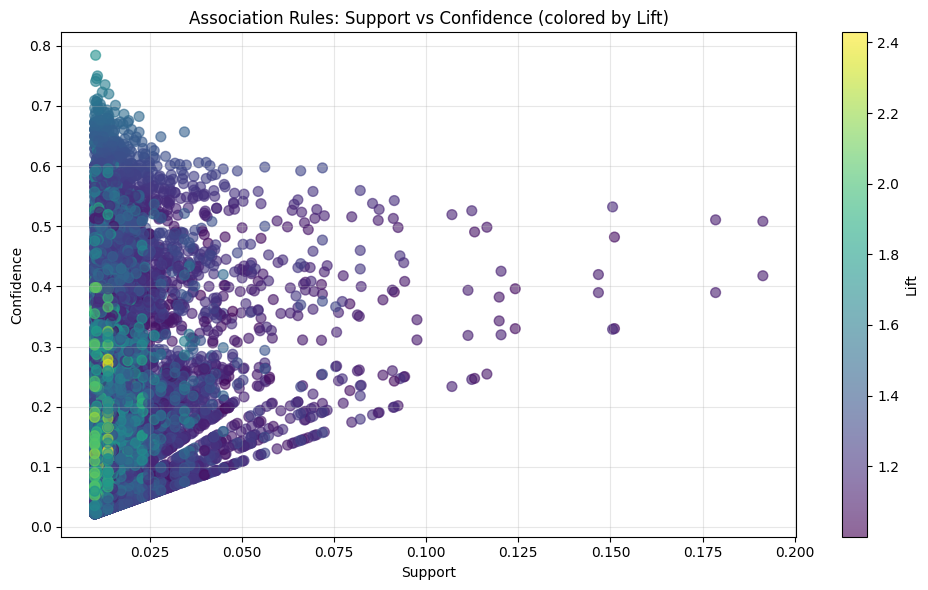

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# 2D scatter plot: Support vs Confidence colored by Lift
plt.figure(figsize=(10, 6))
scatter = plt.scatter(rules['support'], rules['confidence'], 
                     c=rules['lift'], cmap='viridis', alpha=0.6, s=50)
plt.colorbar(scatter, label='Lift')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.title('Association Rules: Support vs Confidence (colored by Lift)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

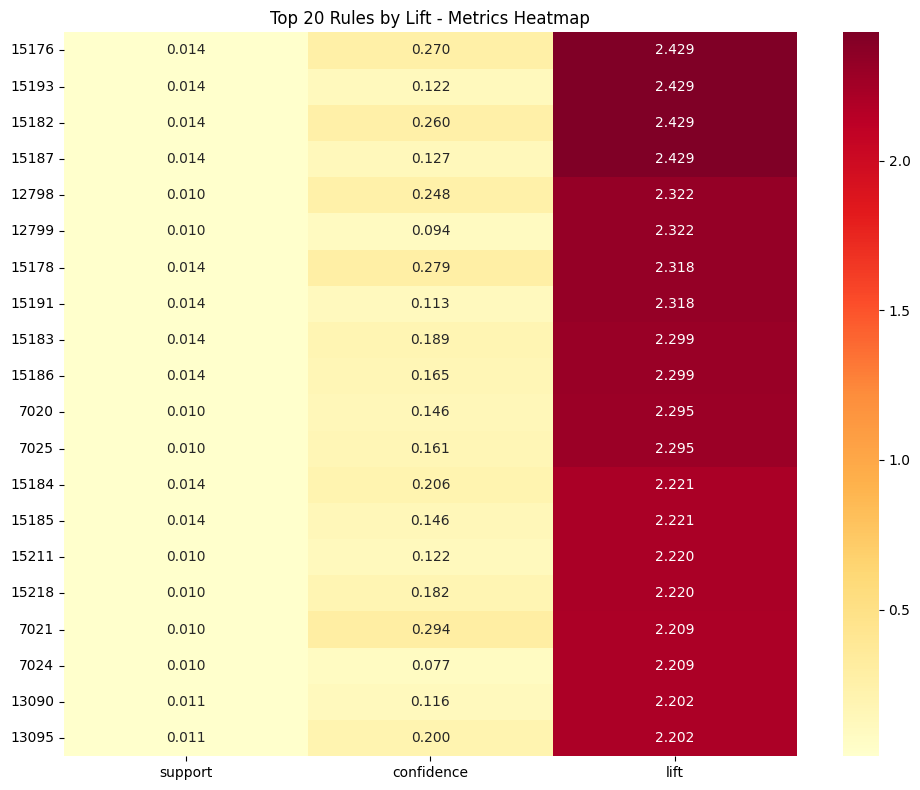

In [13]:
# Heatmap of top rules
top_rules = rules.nlargest(20, 'lift')[['support', 'confidence', 'lift']]

plt.figure(figsize=(10, 8))
sns.heatmap(top_rules, annot=True, fmt='.3f', cmap='YlOrRd')
plt.title('Top 20 Rules by Lift - Metrics Heatmap')
plt.tight_layout()
plt.show()

## Find Specific Item Recommendations

In [14]:
# Helper function to find rules for specific items
def find_rules_for_item(rules, item_name, side='antecedent'):
    """Find rules containing a specific item."""
    if side == 'antecedent':
        mask = rules['antecedents'].apply(lambda x: item_name in x)
    else:
        mask = rules['consequents'].apply(lambda x: item_name in x)
    
    return rules[mask].sort_values(by='lift', ascending=False)

# What do people buy with whole milk?
milk_rules = find_rules_for_item(rules, 'whole milk', side='antecedent')

print("Items commonly bought with whole milk:")
milk_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(15)

Items commonly bought with whole milk:


,antecedents,consequents,support,confidence,lift
15176,"(other vegetables, sausage, whole milk)","(rolls/buns, yogurt)",0.013597,0.270408,2.428689
15187,"(sausage, whole milk)","(other vegetables, rolls/buns, yogurt)",0.013597,0.127098,2.428575
12799,"(sausage, whole milk)","(curd, yogurt)",0.010005,0.093525,2.322046
15178,"(rolls/buns, sausage, whole milk)","(other vegetables, yogurt)",0.013597,0.278947,2.318415
15183,"(other vegetables, whole milk, yogurt)","(rolls/buns, sausage)",0.013597,0.189286,2.298554
7020,"(domestic eggs, whole milk)",(meat),0.010262,0.145985,2.294561
15184,"(rolls/buns, whole milk, yogurt)","(other vegetables, sausage)",0.013597,0.206226,2.220629
15211,"(other vegetables, rolls/buns, whole milk)","(shopping bags, yogurt)",0.010005,0.121875,2.219947
7021,"(meat, whole milk)",(domestic eggs),0.010262,0.294118,2.208999
15181,"(other vegetables, rolls/buns, whole milk)","(sausage, yogurt)",0.013597,0.165625,2.195940


In [15]:
# What leads to buying "other vegetables"?
veggie_rules = find_rules_for_item(rules, 'other vegetables', side='consequent')

print("Items that lead to buying other vegetables:")
veggie_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(15)

Items that lead to buying other vegetables:


,antecedents,consequents,support,confidence,lift
15193,"(rolls/buns, yogurt)","(other vegetables, sausage, whole milk)",0.013597,0.122120,2.428689
15187,"(sausage, whole milk)","(other vegetables, rolls/buns, yogurt)",0.013597,0.127098,2.428575
15178,"(rolls/buns, sausage, whole milk)","(other vegetables, yogurt)",0.013597,0.278947,2.318415
15186,"(rolls/buns, sausage)","(other vegetables, whole milk, yogurt)",0.013597,0.165109,2.298554
15184,"(rolls/buns, whole milk, yogurt)","(other vegetables, sausage)",0.013597,0.206226,2.220629
15218,"(shopping bags, yogurt)","(other vegetables, rolls/buns, whole milk)",0.010005,0.182243,2.219947
13090,"(root vegetables, rolls/buns)","(other vegetables, fruit/vegetable juice)",0.010518,0.115819,2.202260
15188,"(sausage, yogurt)","(other vegetables, rolls/buns, whole milk)",0.013597,0.180272,2.195940
15194,"(whole milk, yogurt)","(other vegetables, sausage, rolls/buns)",0.013597,0.090290,2.159196
13571,"(sausage, pip fruit)","(other vegetables, yogurt)",0.010775,0.256098,2.128504


## Business Insights

In [16]:
# Top 10 strongest associations (by lift)
print("=" * 80)
print("TOP 10 STRONGEST ASSOCIATIONS (Product Placement Strategy)")
print("=" * 80)

top_lift = rules.sort_values(by='lift', ascending=False).head(10)

for idx, row in top_lift.iterrows():
    ant = ', '.join(list(row['antecedents']))
    cons = ', '.join(list(row['consequents']))
    
    print(f"\nRule: {ant} → {cons}")
    print(f"  Lift: {row['lift']:.2f}x (items are {row['lift']:.2f} times more likely together)")
    print(f"  Confidence: {row['confidence']*100:.1f}% (rule is true {row['confidence']*100:.1f}% of the time)")
    print(f"  Support: {row['support']*100:.2f}% ({row['support']*100:.2f}% of all transactions)")

TOP 10 STRONGEST ASSOCIATIONS (Product Placement Strategy)

Rule: other vegetables, sausage, whole milk → rolls/buns, yogurt
  Lift: 2.43x (items are 2.43 times more likely together)
  Confidence: 27.0% (rule is true 27.0% of the time)
  Support: 1.36% (1.36% of all transactions)

Rule: rolls/buns, yogurt → other vegetables, sausage, whole milk
  Lift: 2.43x (items are 2.43 times more likely together)
  Confidence: 12.2% (rule is true 12.2% of the time)
  Support: 1.36% (1.36% of all transactions)

Rule: other vegetables, rolls/buns, yogurt → sausage, whole milk
  Lift: 2.43x (items are 2.43 times more likely together)
  Confidence: 26.0% (rule is true 26.0% of the time)
  Support: 1.36% (1.36% of all transactions)

Rule: sausage, whole milk → other vegetables, rolls/buns, yogurt
  Lift: 2.43x (items are 2.43 times more likely together)
  Confidence: 12.7% (rule is true 12.7% of the time)
  Support: 1.36% (1.36% of all transactions)

Rule: sausage, whole milk → curd, yogurt
  Lift: 2.3

In [17]:
# Most frequent item combinations (by support)
print("=" * 80)
print("TOP 10 MOST FREQUENT COMBINATIONS (Cross-Selling Strategy)")
print("=" * 80)

top_support = rules.sort_values(by='support', ascending=False).head(10)

for idx, row in top_support.iterrows():
    ant = ', '.join(list(row['antecedents']))
    cons = ', '.join(list(row['consequents']))
    
    print(f"\n{ant} + {cons}")
    print(f"  Appears in {row['support']*100:.2f}% of transactions")
    print(f"  Confidence: {row['confidence']*100:.1f}%")

TOP 10 MOST FREQUENT COMBINATIONS (Cross-Selling Strategy)

other vegetables + whole milk
  Appears in 19.14% of transactions
  Confidence: 50.8%

whole milk + other vegetables
  Appears in 19.14% of transactions
  Confidence: 41.8%

rolls/buns + whole milk
  Appears in 17.86% of transactions
  Confidence: 51.1%

whole milk + rolls/buns
  Appears in 17.86% of transactions
  Confidence: 39.0%

soda + whole milk
  Appears in 15.11% of transactions
  Confidence: 48.2%

whole milk + soda
  Appears in 15.11% of transactions
  Confidence: 33.0%

whole milk + yogurt
  Appears in 15.06% of transactions
  Confidence: 32.9%

yogurt + whole milk
  Appears in 15.06% of transactions
  Confidence: 53.2%

other vegetables + rolls/buns
  Appears in 14.67% of transactions
  Confidence: 39.0%

rolls/buns + other vegetables
  Appears in 14.67% of transactions
  Confidence: 42.0%


## Save Results

In [18]:
# Save all rules to CSV
output_path = Path('../outputs/association')
output_path.mkdir(parents=True, exist_ok=True)

# Convert frozenset to string for CSV export
rules_export = rules.copy()
rules_export['antecedents'] = rules_export['antecedents'].apply(lambda x: ', '.join(list(x)))
rules_export['consequents'] = rules_export['consequents'].apply(lambda x: ', '.join(list(x)))

rules_export.to_csv(output_path / 'association_rules.csv', index=False)
print(f"\n✅ Rules saved to: {output_path / 'association_rules.csv'}")
print(f"Total rules exported: {len(rules_export)}")


✅ Rules saved to: ../outputs/association/association_rules.csv
Total rules exported: 15260


In [19]:
# Save frequent itemsets
frequent_itemsets_export = frequent_itemsets.copy()
frequent_itemsets_export['itemsets'] = frequent_itemsets_export['itemsets'].apply(lambda x: ', '.join(list(x)))

frequent_itemsets_export.to_csv(output_path / 'frequent_itemsets.csv', index=False)
print(f"✅ Frequent itemsets saved to: {output_path / 'frequent_itemsets.csv'}")
print(f"Total itemsets exported: {len(frequent_itemsets_export)}")

✅ Frequent itemsets saved to: ../outputs/association/frequent_itemsets.csv
Total itemsets exported: 3016


## Conclusion

In this tutorial, we:

1. ✅ Loaded the Groceries market basket dataset
2. ✅ Explored item frequencies and popular products
3. ✅ Converted transactions to one-hot encoded format
4. ✅ Generated frequent itemsets using Apriori algorithm
5. ✅ Created association rules with MLxtend
6. ✅ Filtered rules by confidence, support, and lift
7. ✅ Visualized rules with scatter plots and heatmaps
8. ✅ Found recommendations for specific items
9. ✅ Extracted business insights
10. ✅ Saved results for deployment

### Key Takeaways

- **Support** shows frequency - use for popular combinations
- **Confidence** shows reliability - use for strong recommendations
- **Lift** shows correlation - use for discovering unexpected patterns
- MLxtend provides robust implementation of Apriori and association rules
- One-hot encoding is required for transaction data

### Business Applications

1. **Product Placement** - Place high-lift items near each other
2. **Cross-Selling** - Recommend high-confidence consequents
3. **Promotions** - Bundle high-support combinations
4. **Inventory** - Stock complementary products together

### Next Steps

- Experiment with different support/confidence thresholds
- Analyze seasonal patterns (using Date column)
- Segment customers and find group-specific rules
- Deploy rules to a recommendation engine
- A/B test product placements based on discovered rules

### Resources

- **MLxtend Documentation:** http://rasbt.github.io/mlxtend/
- **Association Rules:** http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/association_rules/
- **Apriori Algorithm:** http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/

---

**Note:** PyCaret 3.x removed the `arules` module. This tutorial uses MLxtend, which is the industry-standard library for association rule mining in Python.